# Análise dos testes

### Carregamento dos testes

In [13]:
from json import load
from collections import OrderedDict

tests_paths = OrderedDict({
    'LLaMA-3.2-11B-Vision-Instruct (Quantizado)': '../analysis/Llama-3.2-11B-Vision-Instruct_test_class_only_quantized.json',
    'LLaMA-3.2-11B-Vision-Instruct': '../analysis/Llama-3.2-11B-Vision-Instruct_test_class_only.json',
    'LLaMA com QLoRA (450 amostras)': '../analysis/LLaMA_DERM_QLoRA_500_11B_test_class_only.json',
    'LLaMA com QLoRA (900 amostras)': '../analysis/LLaMA_DERM_QLoRA_1000_11B_test_class_only.json',
    'LLaMA com QLoRA (1800 amostras)': '../analysis/LLaMA_DERM_QLoRA_2000_11B_test_class_only.json',
    'LLaMA com QLoRA (5000 amostras)': '../analysis/LLaMA_DERM_QLoRA_5000_11B_test_class_only.json',
    'LLaMA com QLoRA (9500 amostras)': '../analysis/LLaMA_DERM_QLoRA_9500_11B_test_class_only.json',
    'LLaMA com LoRA (450 amostras)': '../analysis/LLaMA_DERM_LoRA_500_11B_test_class_only.json',
    'LLaMA com LoRA (900 amostras)': '../analysis/LLaMA_DERM_LoRA_1000_11B_test_class_only.json',
    'LLaMA com LoRA (5000 amostras)': '../analysis/LLaMA_DERM_LoRA_5000_11B_test_class_only.json'
})

tests = OrderedDict({k: load(open(v)) for k, v in tests_paths.items()})

### Contagem das classes

In [14]:
from IPython.display import display, HTML
import pandas as pd
from collections import Counter


def create_distribution_table(counter: Counter, total: int, title: str) -> pd.DataFrame:
    '''
    Cria um DataFrame formatado a partir dos dados de um contador.
    '''

    df = pd.DataFrame([
        {
            'Answer': answer if len(answer) < 50 else answer[:51] + '...',
            'Count': count,
            'Percentage': count/total * 100
        }
        for answer, count in counter.items()
    ])

    df = df.sort_values('Count', ascending=False)
    df['Percentage'] = df['Percentage'].map('{:.1f}%'.format)

    styled_df = df.style.set_caption(title).set_table_styles([
        {'selector': 'caption', 'props': [('font-weight', 'bold'), ('font-size', '120%')]},
        {'selector': 'th', 'props': [('text-align', 'left'), ('background-color', '#f0f0f0')]},
        {'selector': 'table', 'props': [('width', '100%')]},
    ]).hide(axis='index')

    return styled_df


def display_model_results(model_name: str, test_data: list[dict[str, str]]):
    '''
    Exibe a distribuição em tabela dos resultados esperados vs reais para um modelo.
    '''

    results = test_data['results']
    expected_counter = Counter(item['expected'] for item in results)
    actual_counter = Counter(item['actual'] for item in results)

    total = len(results)

    display(HTML(f'<h2>{model_name}</h2>'))
    display(HTML("""
    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px;">
        <div>
            """ + create_distribution_table(expected_counter, total, 'Expected Classes Distribution').to_html() + """
        </div>
        <div>
            """ + create_distribution_table(actual_counter, total, 'Model Predictions Distribution').to_html() + """
        </div>
    </div>
    <br><hr><br>
    """))


for model_name, test_data in tests.items():
    display_model_results(model_name, test_data)

Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
Melanoma.,976,97.6%
Melanocytic Nevi.,13,1.3%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
Melanoma.,883,88.3%
Dermatofibroma.,64,6.4%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
The skin lesion in the image is melanocytic Nevi.,737,73.7%
The skin lesion in the image is melanoma.,149,14.9%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
Melanocytic Nevi.,582,58.2%
Melanoma.,213,21.3%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi.,677,67.7%
melanoma.,151,15.1%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
The skin lesion in the image is melanocytic Nevi.,699,69.9%
The skin lesion in the image is melanoma.,113,11.3%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
The skin lesion in the image is melanocytic Nevi.,742,74.2%
The skin lesion in the image is benign keratosis-li...,78,7.8%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
Melanocytic Nevi.,598,59.8%
Melanoma.,384,38.4%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
Melanoma.,567,56.7%
Melanocytic Nevi.,408,40.8%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
The skin lesion in the image is melanocytic Nevi.,716,71.6%
The skin lesion in the image is melanoma.,117,11.7%


### Processamento dos testes

In [15]:
from collections import Counter

DISEASE_CLASSES = [
    'melanocytic Nevi',
    'melanoma',
    'benign keratosis-like lesions',
    'basal cell carcinoma',
    'actinic keratoses',
    'vascular lesions',
    'dermatofibroma'
]


def normalize_disease(text: str) -> str:
    '''
    Normaliza o nome da doença para um formato padrão.
    '''

    text = text.lower().strip().strip('.')

    variations = {
        'melanocytic nevi': 'melanocytic Nevi',
        'nevus': 'melanocytic Nevi',
        'nevi': 'melanocytic Nevi',
        'benign keratosis': 'benign keratosis-like lesions',
        'seborrheic keratosis': 'benign keratosis-like lesions',
        'basal cell': 'basal cell carcinoma',
        'actinic keratosis': 'actinic keratoses',
        'vascular': 'vascular lesions'
    }

    for variant, standard in variations.items():
        if variant in text:
            return standard

    return text


def classify_answer(text: str) -> str:
    '''
    Classifica a resposta do modelo em uma classe de doença padrão ou incerta.
    '''

    text = text.lower()

    mentioned_diseases = []
    for disease in DISEASE_CLASSES:
        if disease.lower() in text:
            mentioned_diseases.append(disease)

    if len(mentioned_diseases) != 1:
        return 'unclear answer'
    else:
        return mentioned_diseases[0]


def process_and_display_results(model_name: str, test_data: list[dict[str, str]]) -> list[tuple[str, str]]:
    '''
    Processa e exibe os resultados com classificações padronizadas. Retorna uma lista de pares (esperado, classificado).
    '''

    results = test_data['results']
    total = len(results)

    processed_results = [
        {
            'expected': result['expected'],
            'actual': result['actual'],
            'classified': classify_answer(result['actual'])
        }
        for result in results
    ]

    pairs = [(r['expected'], r['classified']) for r in processed_results]

    expected_counter = Counter(item['expected'] for item in processed_results)
    classified_counter = Counter(item['classified'] for item in processed_results)

    display(HTML(f'<h2>{model_name}</h2>'))
    display(HTML("""
    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px;">
        <div>
            """ + create_distribution_table(expected_counter, total, 'Expected Classes').to_html() + """
        </div>
        <div>
            """ + create_distribution_table(classified_counter, total, 'Classified Predictions').to_html() + """
        </div>
    </div>
    <br><hr><br>
    """))

    return pairs


all_results = {}

for model_name, test_data in tests.items():
    all_results[model_name] = process_and_display_results(model_name, test_data)

Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanoma,976,97.6%
melanocytic Nevi,13,1.3%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanoma,883,88.3%
dermatofibroma,64,6.4%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,812,81.2%
melanoma,171,17.1%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,602,60.2%
melanoma,238,23.8%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,689,68.9%
melanoma,151,15.1%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,699,69.9%
melanoma,113,11.3%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,742,74.2%
benign keratosis-like lesions,78,7.8%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,598,59.8%
melanoma,384,38.4%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanoma,567,56.7%
melanocytic Nevi,408,40.8%


Answer,Count,Percentage
melanocytic Nevi,668,66.8%
melanoma,112,11.2%
benign keratosis-like lesions,110,11.0%
basal cell carcinoma,52,5.2%
actinic keratoses,33,3.3%
vascular lesions,14,1.4%
dermatofibroma,11,1.1%
Answer,Count,Percentage
melanocytic Nevi,716,71.6%
melanoma,117,11.7%


### Análise

Acurária dos modelos:


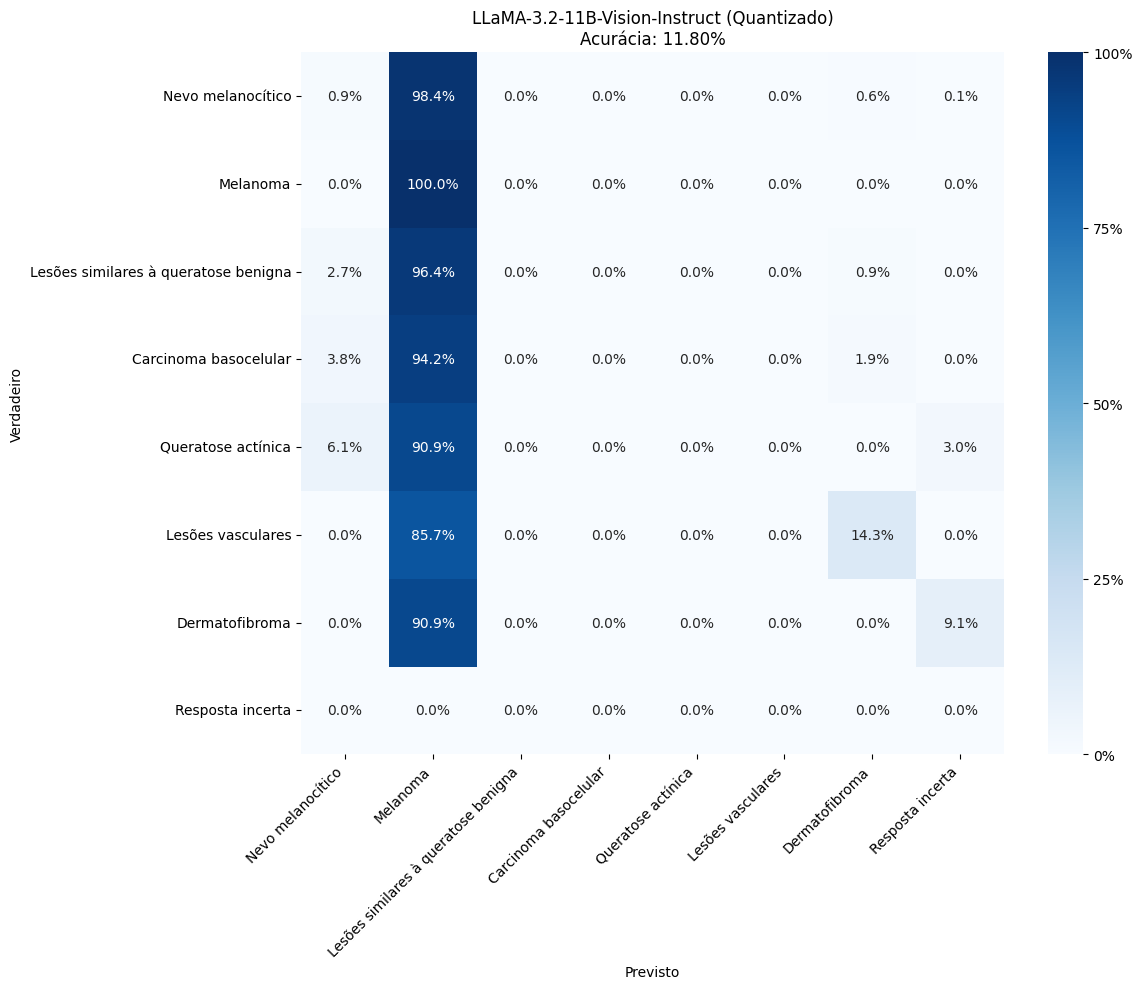

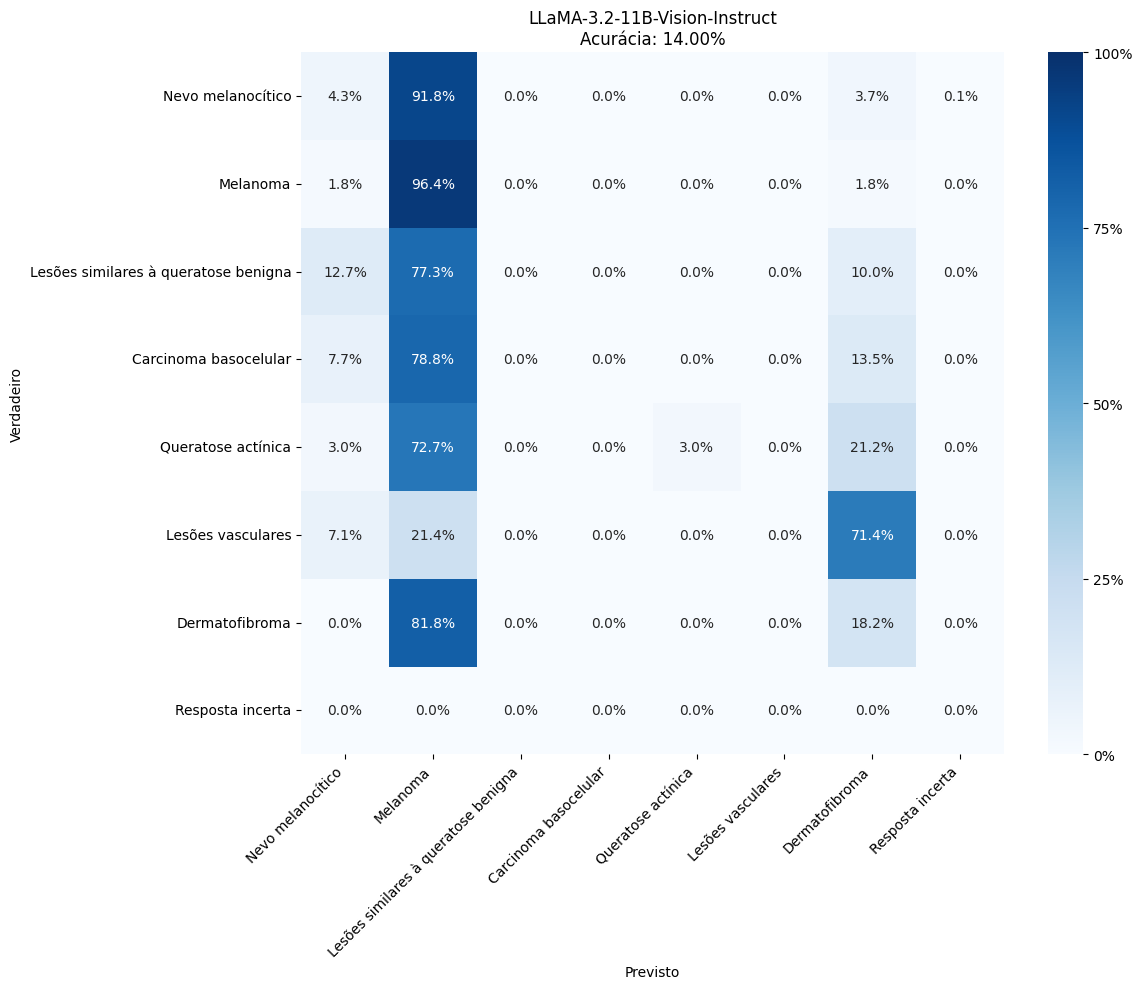

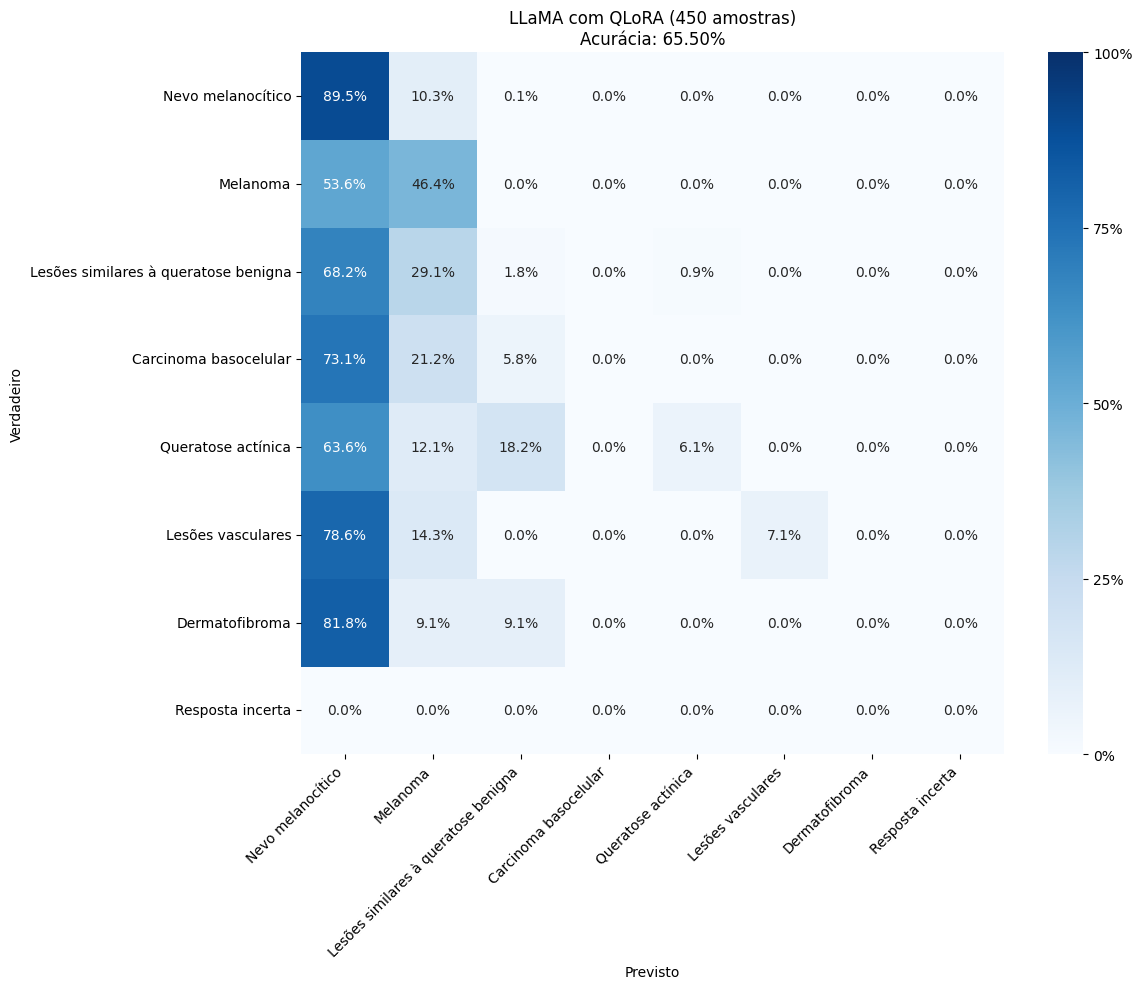

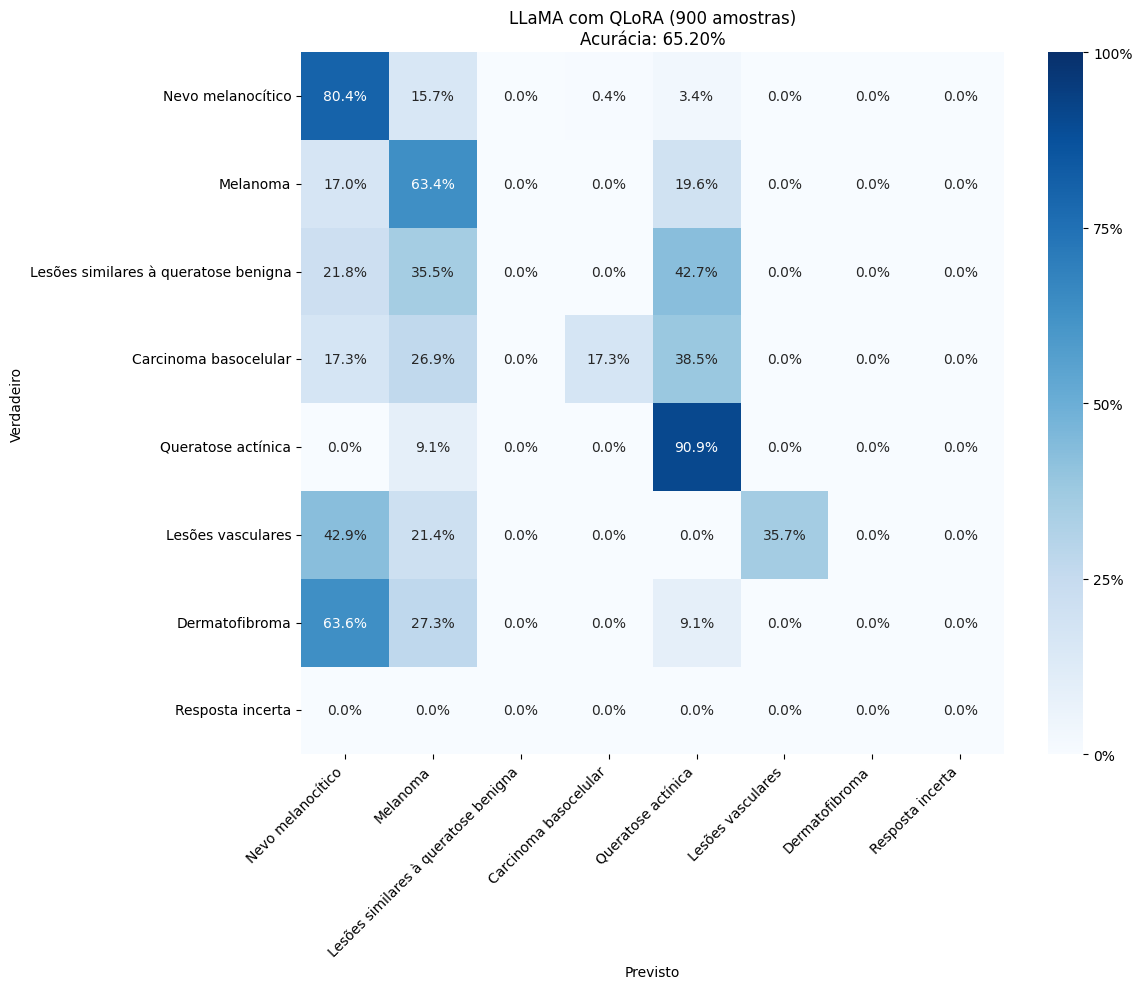

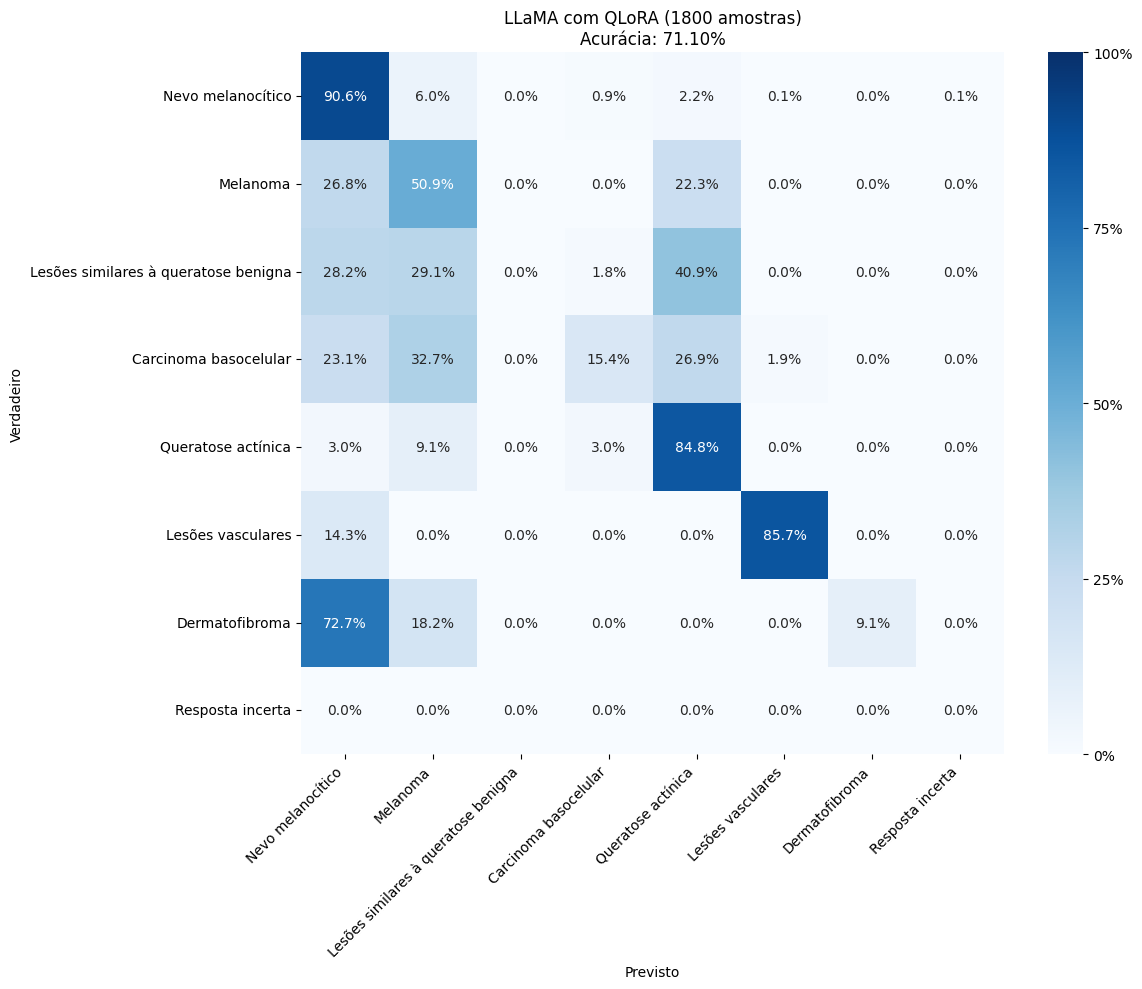

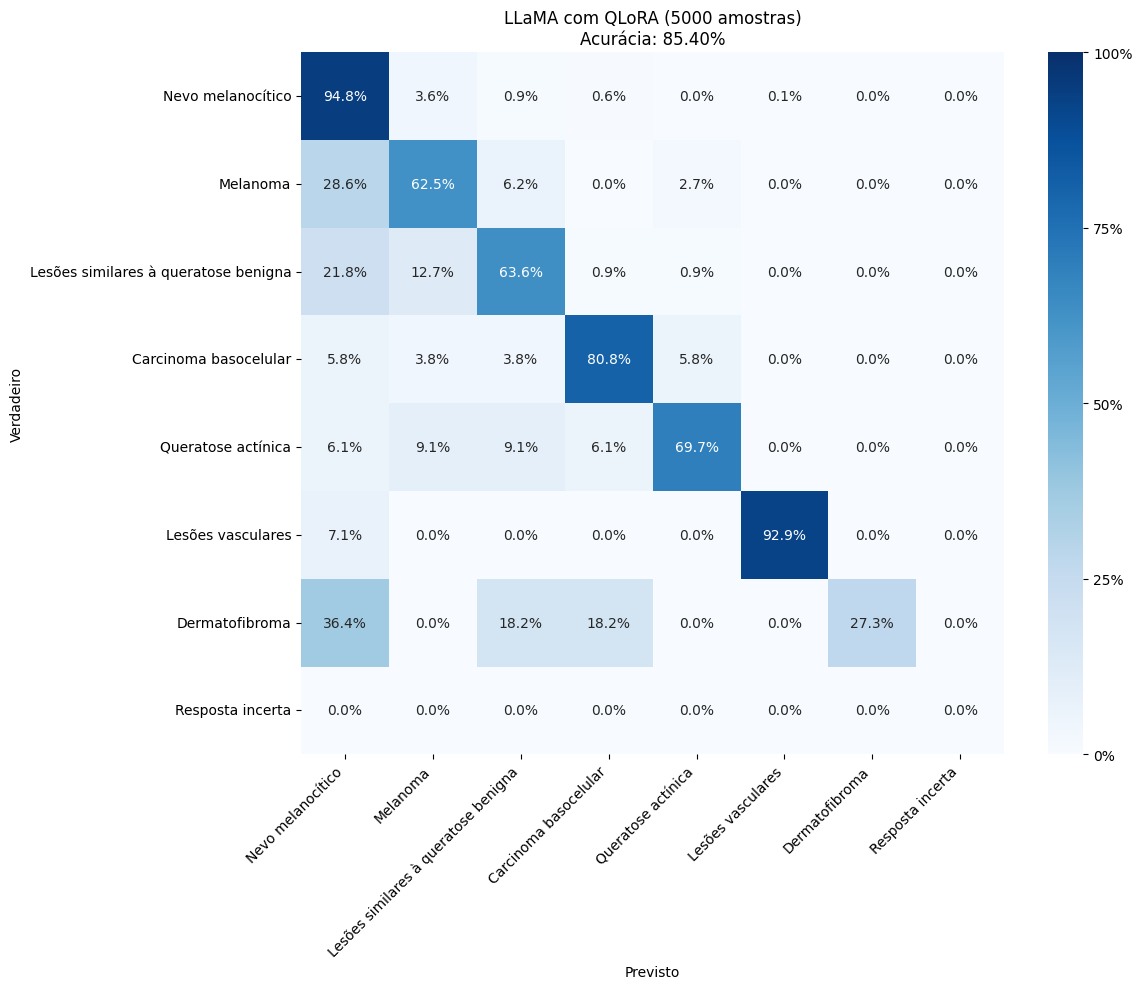

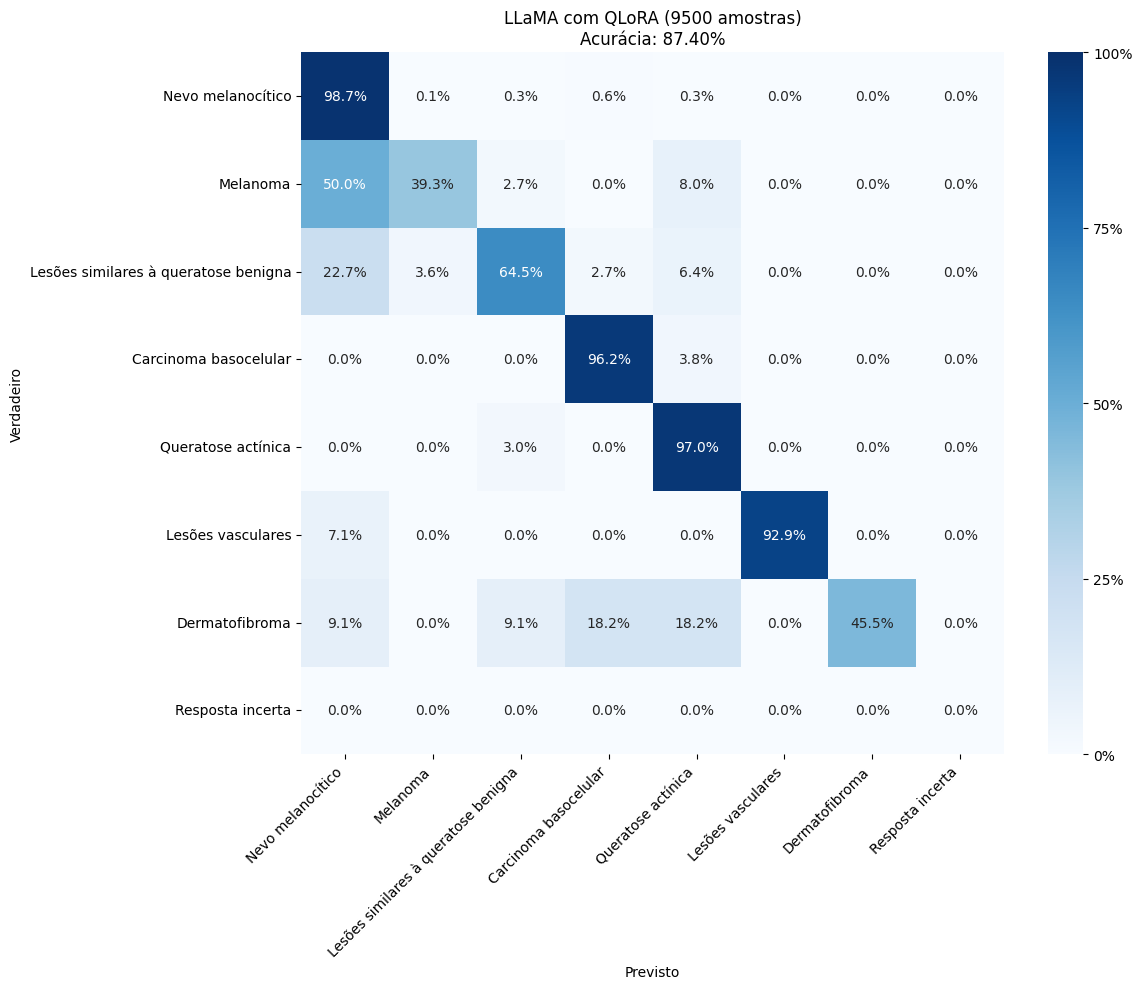

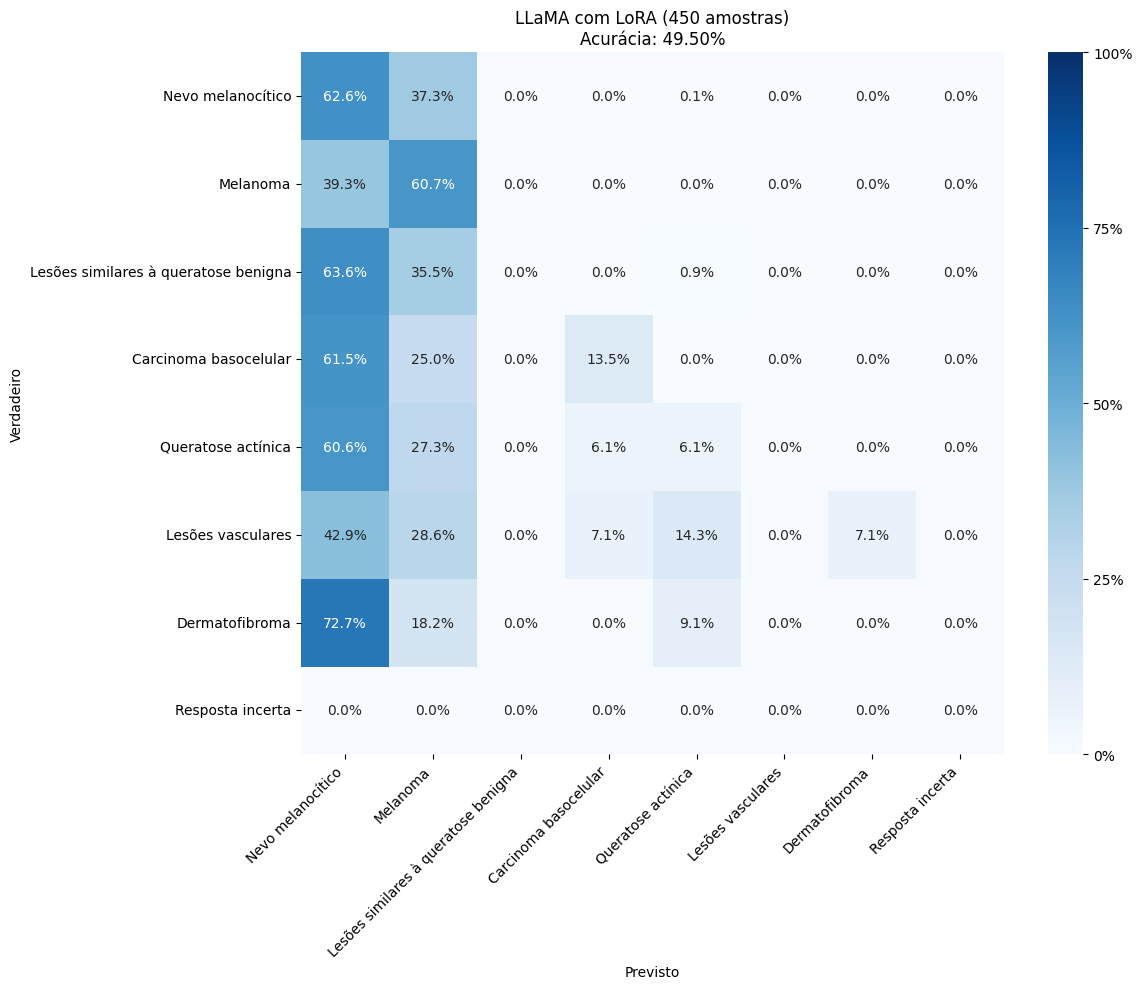

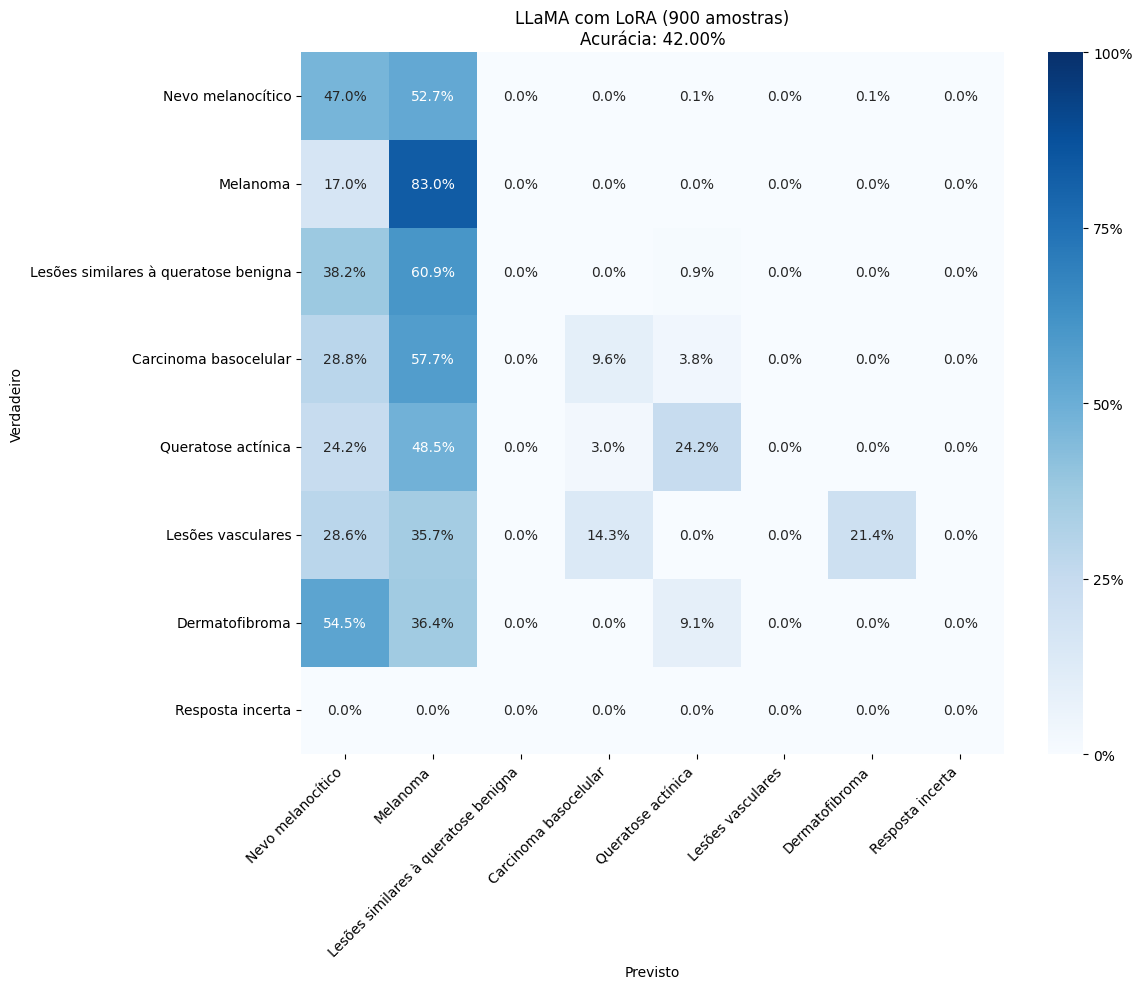

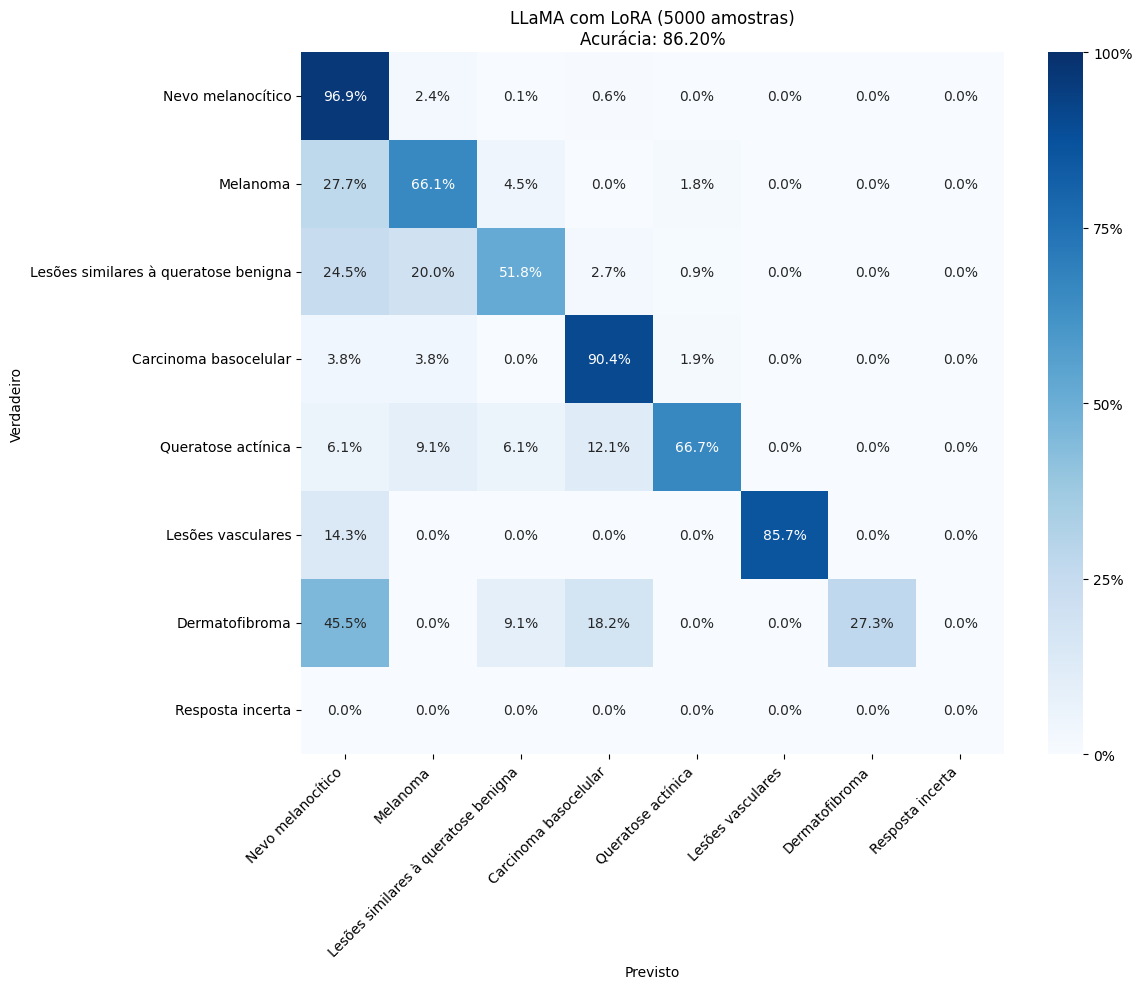

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix


def analyze_model_performance(pairs: list[tuple[str, str]], model_name: str):
    '''
    Calcula a acurácia e cria uma visualização da matriz de confusão normalizada.
    '''

    class_pt_translations = {
        'melanocytic Nevi': 'Nevo melanocítico',
        'melanoma': 'Melanoma',
        'benign keratosis-like lesions': 'Lesões similares à queratose benigna',
        'basal cell carcinoma': 'Carcinoma basocelular',
        'actinic keratoses': 'Queratose actínica',
        'vascular lesions': 'Lesões vasculares',
        'dermatofibroma': 'Dermatofibroma',
        'unclear answer': 'Resposta incerta'
    }

    y_true = [p[0] for p in pairs]
    x_pred = [p[1] for p in pairs]

    accuracy = accuracy_score(y_true, x_pred)

    labels = DISEASE_CLASSES + ['unclear answer']

    pt_labels = [class_pt_translations[label] for label in labels]
    pt_y_true = [class_pt_translations[label] for label in y_true]
    pt_x_pred = [class_pt_translations[label] for label in x_pred]

    cm = confusion_matrix(pt_y_true, pt_x_pred, labels=pt_labels, normalize='true')

    plt.figure(figsize=(12, 10))
    heat_map = sns.heatmap(cm,
                           annot=True,
                           fmt='.1%',
                           cmap='Blues',
                           xticklabels=pt_labels,
                           yticklabels=pt_labels,
                           vmin=0,
                           vmax=1)
    color_bar = heat_map.collections[0].colorbar
    color_bar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    color_bar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    plt.title(f'{model_name}\nAcurácia: {accuracy:.2%}')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'../plots/{model_name}.png', dpi=300)
    plt.show()

    return accuracy


accuracies = {}
for model_name, pairs in all_results.items():
    accuracies[model_name] = analyze_model_performance(pairs, model_name)